In [1]:
import os
os.chdir("..")

In [2]:
from roboflow import Roboflow
from dotenv import load_dotenv
import shutil

load_dotenv()
ROBOFLOW_API_KEY = os.getenv("ROBOFLOW_API_KEY")


rf = Roboflow(api_key=ROBOFLOW_API_KEY)
project = rf.workspace("brad-dwyer").project("car-parts-pgo19")
version = project.version(6)
dataset = version.download("sam2")

target_path = os.path.join(os.getcwd(), "data")
shutil.move(dataset.location, target_path)


In [2]:
!git clone https://github.com/facebookresearch/sam2.git

Cloning into 'sam2'...
remote: Enumerating objects: 1052, done.
remote: Counting objects: 100% (447/447), done.
remote: Compressing objects: 100% (194/194), done.
remote: Total 1052 (delta 275), reused 288 (delta 253), pack-reused 605 (from 1)
Receiving objects: 100% (1052/1052), 121.74 MiB | 6.59 MiB/s, done.
Resolving deltas: 100% (378/378), done.


In [3]:
!wget -O sam2/sam2/configs/train.yaml 'https://drive.usercontent.google.com/download?id=11cmbxPPsYqFyWq87tmLgBAQ6OZgEhPG3'
     

--2024-12-15 21:07:11--  https://drive.usercontent.google.com/download?id=11cmbxPPsYqFyWq87tmLgBAQ6OZgEhPG3
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.203.193, 2a00:1450:401b:810::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.203.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11055 (11K) [application/octet-stream]
Saving to: ‘sam2/sam2/configs/train.yaml’

sam2/sam2/configs/t 100%[===================>]  10,80K  --.-KB/s    in 0,003s  

2024-12-15 21:07:13 (3,09 MB/s) - ‘sam2/sam2/configs/train.yaml’ saved [11055/11055]



In [3]:
%cd ./sam2/

/home/mikolaj/work/SAM-2.1_fine_tuning/sam2


This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.


In [4]:
print(os.getcwd())

/home/mikolaj/work/SAM-2.1_fine_tuning/sam2


In [6]:
!pip install -e .[dev] -q


[notice] A new release of pip is available: 24.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [7]:
!cd ./checkpoints && ./download_ckpts.sh

--2024-12-15 21:09:36--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_tiny.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.244.102.110, 18.244.102.12, 18.244.102.64, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.244.102.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156008466 (149M) [application/vnd.snesdev-page-table]
Saving to: ‘sam2.1_hiera_tiny.pt’

sam2.1_hiera_tiny.p 100%[===================>] 148,78M  11,1MB/s    in 14s     

2024-12-15 21:09:50 (10,9 MB/s) - ‘sam2.1_hiera_tiny.pt’ saved [156008466/156008466]

--2024-12-15 21:09:50--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_small.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.244.102.73, 18.244.102.12, 18.244.102.110, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.244.102.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 184416285 (176

In [8]:
# Script to rename roboflow filenames to something SAM 2.1 compatible.
import os
import re

FOLDER = "/home/mikolaj/work/SAM-2.1_fine_tuning/data/train"

for filename in os.listdir(FOLDER):
    # Replace all except last dot with underscore
    new_filename = filename.replace(".", "_", filename.count(".") - 1)
    if not re.search(r"_\d+\.\w+$", new_filename):
        # Add an int to the end of base name
        new_filename = new_filename.replace(".", "_1.")
    os.rename(os.path.join(FOLDER, filename), os.path.join(FOLDER, new_filename))

print(len(os.listdir(FOLDER)))

76


In [6]:
#Run comand below from terminal for less VRAM usage
# !PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True python training/train.py -c 'configs/train.yaml' --use-cluster 0 --num-gpus 1

###################### Train App Config ####################
scratch:
  resolution: 512
  train_batch_size: 1
  num_train_workers: 1
  num_frames: 1
  max_num_objects: 3
  base_lr: 5.0e-06
  vision_lr: 3.0e-06
  phases_per_epoch: 1
  num_epochs: 40
dataset:
  img_folder: /home/mikolaj/work/SAM-2.1_fine_tuning/data/train
  gt_folder: /home/mikolaj/work/SAM-2.1_fine_tuning/data/train
  multiplier: 2
vos:
  train_transforms:
  - _target_: training.dataset.transforms.ComposeAPI
    transforms:
    - _target_: training.dataset.transforms.RandomHorizontalFlip
      consistent_transform: true
    - _target_: training.dataset.transforms.RandomAffine
      degrees: 25
      shear: 20
      image_interpolation: bilinear
      consistent_transform: true
    - _target_: training.dataset.transforms.RandomResizeAPI
      sizes: ${scratch.resolution}
      square: true
      consistent_transform: true
    - _target_: training.dataset.transforms.ColorJitter
      consistent_transform: true
      brigh

In [5]:
%load_ext tensorboard
%tensorboard --bind_all --logdir ./sam2_logs/

Launching TensorBoard...

In [6]:
!pip install supervision -q
     


[notice] A new release of pip is available: 24.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [7]:
print(os.getcwd())
# os.chdir("sam2")
print(os.getcwd())

/home/mikolaj/work/SAM-2.1_fine_tuning/sam2
/home/mikolaj/work/SAM-2.1_fine_tuning/sam2


In [4]:
import torch
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
import supervision as sv
import os
import random
from PIL import Image
import numpy as np

# use bfloat16 for the entire notebook
# from Meta notebook
# torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
torch.autocast("cuda", dtype=torch.float32).__enter__()
# if torch.cuda.get_device_properties(0).major >= 8:
#     torch.backends.cuda.matmul.allow_tf32 = True
#     torch.backends.cudnn.allow_tf32 = True

checkpoint = "sam2_logs/configs/train.yaml/checkpoints/checkpoint.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_b+.yaml"
sam2 = build_sam2(model_cfg, checkpoint, device="cuda")
mask_generator = SAM2AutomaticMaskGenerator(sam2)

print(os.getcwd())
checkpoint_base = "checkpoints/sam2.1_hiera_base_plus.pt"
model_cfg_base = "configs/sam2.1/sam2.1_hiera_b+.yaml"
sam2_base = build_sam2(model_cfg_base, checkpoint_base, device="cuda")
mask_generator_base = SAM2AutomaticMaskGenerator(sam2_base)

/home/mikolaj/work/SAM-2.1_fine_tuning/sam2


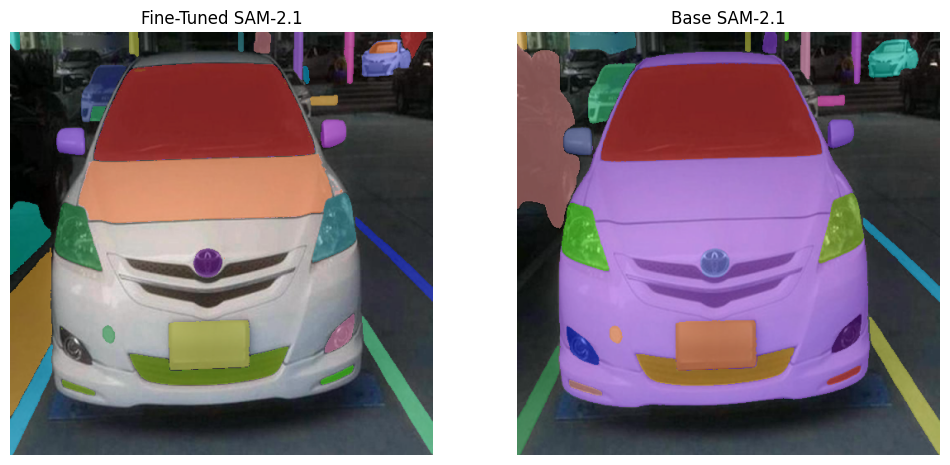

In [5]:
validation_set = os.listdir("../data/valid")

# choose random with .json extension
image = random.choice([img for img in validation_set if img.endswith(".jpg")])
image = os.path.join("../data/valid", image)
# opened_image = np.array(Image.open(image).convert("RGB"))
opened_image = np.array(Image.open(image).convert("RGB").resize((512, 512)))
result = mask_generator.generate(opened_image)

detections = sv.Detections.from_sam(sam_result=result)

mask_annotator = sv.MaskAnnotator(color_lookup = sv.ColorLookup.INDEX)
annotated_image = opened_image.copy()
annotated_image = mask_annotator.annotate(annotated_image, detections=detections)

base_annotator = sv.MaskAnnotator(color_lookup = sv.ColorLookup.INDEX)

base_result = mask_generator_base.generate(opened_image)
base_detections = sv.Detections.from_sam(sam_result=base_result)
base_annotated_image = opened_image.copy()
base_annotated_image = base_annotator.annotate(base_annotated_image, detections=base_detections)

sv.plot_images_grid(images=[annotated_image, base_annotated_image], titles=["Fine-Tuned SAM-2.1", "Base SAM-2.1"], grid_size=(1, 2))
     